In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from all_models import dual_model_sudden, dual_model_gradual, model_sudden, model_gradual
import scipy.stats as stat

In [3]:
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90

In [17]:
ti = pickle.load(open('train_indices_704.pickle', 'rb'))
ti.shape

(100, 60)

In [35]:
curvatures = pickle.load(open('curvatures_smooth_all.pickle', 'rb'))
curvatures.shape

(64, 12, 64)

In [36]:
sp = pickle.load(open('fit_dual_CV_640_bestfit_starting_point.pickle', 'rb'))
sp.shape

(64, 6)

In [39]:
sp[0]

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [4]:
num_participants = 32
dual_errors = np.zeros((100, num_participants, 704))
single_errors = np.zeros((100, num_participants, 704))
for i in range(100):
    for participant in range(num_participants):
        if participant%2 == 0:
            dual_errors[i][participant] = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            single_errors[i][participant] = model_sudden(704, fits_single[i][participant][0], fits_single[i][participant][1])[0]
        else:
            dual_errors[i][participant] = dual_model_gradual(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            single_errors[i][participant] = model_gradual(704, fits_single[i][participant][0], fits_single[i][participant][1])[0]

In [5]:
ll_single = np.zeros((100, num_participants, 704))
ll_dual = np.zeros((100, num_participants, 704))
for i in range(100):
    for participant in range(num_participants):
        ll_dual[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), dual_errors[i][participant], fits_dual[i][participant][5])
        ll_single[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), single_errors[i][participant], fits_single[i][participant][3])

In [6]:
def get_lls(fits, ll, num_participants):
    ll_rotate_train = np.zeros((100, num_participants))
    ll_transfer_train = np.zeros((100, num_participants))
    ll_rotate_test = np.zeros((100, num_participants))
    ll_transfer_test = np.zeros((100, num_participants))
    ll_all_test = np.zeros((100, num_participants))
    ll_all_train = np.zeros((100, num_participants))

    for i in range(100):
        for participant in range(num_participants):
            rotate_train_indices = fits[i][participant, -1][fits[i][participant, -1] < 640]
            transfer_train_indices = fits[i][participant, -1][fits[i][participant, -1] >= 640]
            
            all_test_indices = np.delete(range(704), fits[i][participant, -1])
            rotate_test_indices = all_test_indices[all_test_indices<640]
            transfer_test_indices = all_test_indices[all_test_indices>=640]
            #if rotate:
            ll_rotate_train[i][participant] = sum(ll[i][participant][rotate_train_indices])
            ll_rotate_test[i][participant] = sum(ll[i][participant][rotate_test_indices])
            #else:
            ll_transfer_train[i][participant] = sum(ll[i][participant][transfer_train_indices])
            ll_transfer_test[i][participant] = sum(ll[i][participant][transfer_test_indices])
            #Uncomment for combined rotate + transfer
            ll_all_test[i][participant] = sum(ll[i][participant][all_test_indices])
            ll_all_train[i][participant] = sum(ll[i][participant][fits[i][participant, -1]])
            
    return [ll_rotate_train, ll_rotate_test, ll_transfer_train, ll_transfer_test, ll_all_train, ll_all_test]

In [7]:
ll_duals = np.array(get_lls(fits_dual, ll_dual, 32))
ll_singles = np.array(get_lls(fits_single, ll_single, 32))

In [8]:
def get_train_test_split(ll_selected, ll_compared, model_selected, num_participants):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', num_participants), np.repeat('Gradual', num_participants)))),
     'Set': np.ravel(np.row_stack((np.repeat('Train', num_participants/2), np.repeat('Test', num_participants/2), np.repeat('Train', num_participants/2), np.repeat('Test', num_participants/2))))}
    df = pd.DataFrame(d)
    df[model_selected] = np.concatenate((
    sum(ll_compared[4][:, 0::2] <= ll_selected[4][:, 0::2]), 
    sum(ll_compared[5][:, 0::2] <= ll_selected[5][:, 0::2]),

    sum(ll_compared[4][:, 1::2] <= ll_selected[4][:, 1::2]), 
    sum(ll_compared[5][:, 1::2] <= ll_selected[5][:, 1::2]),
    ))
    return df

In [9]:
df_train_test = get_train_test_split(ll_duals, ll_singles, "Dual_Selected", 32)

Text(0.5, 0.98, 'Compared to Single')

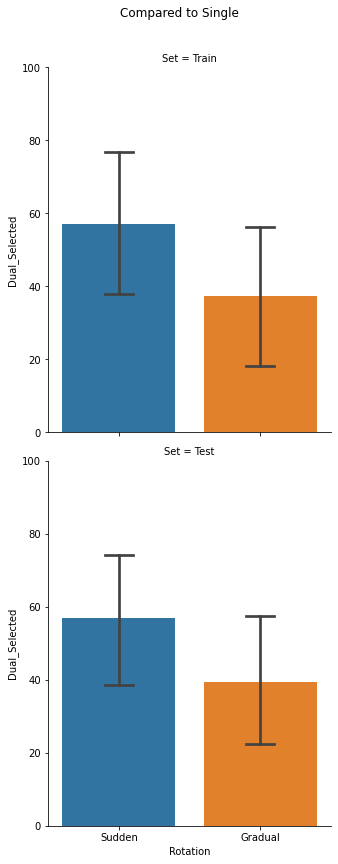

In [10]:
g = sns.catplot(x="Rotation", y="Dual_Selected", row="Set", 
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_train_test)
plt.subplots_adjust(top=0.91)
plt.ylim((0, 100))
g.fig.suptitle('Compared to Single')


In [44]:
df_train_test['Model_Selected'] = 1

In [45]:
df_train_test['Model_Selected'][df_train_test['Dual_Selected'] < 50] = 0

<ipython-input-45-55495f3cb61d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test['Model_Selected'][df_train_test['Dual_Selected'] < 50] = 0


In [49]:
df_train_test.groupby(['Rotation', 'Set']).sum()

Dual_Selected  Model_Selected
Rotation Set                                 
Gradual  Test             631               7
         Train            599               7
Sudden   Test             910              11
         Train            914              10

In [47]:
df_train_test

,Rotation,Set,Dual_Selected,Model_Selected
0,Sudden,Train,96,1
1,Sudden,Train,0,0
2,Sudden,Train,86,1
3,Sudden,Train,90,1
4,Sudden,Train,0,0
...,...,...,...,...
59,Gradual,Test,73,1
60,Gradual,Test,1,0
61,Gradual,Test,0,0
62,Gradual,Test,42,0
